# Connect to Mongo Atlas

This needs the following variables in `.env` file.  Replace `ATLAS_URI`, you can get this value from your atlas UI.


```text
ATLAS_URI=mongodb+srv://<username>:<password>@sandbox.lqlql.mongodb.net/?retryWrites=true&w=majority
DB_NAME=sample_mflix
```

References

- https://www.mongodb.com/developer/products/atlas/semantic-search-mongodb-atlas-vector-search/
- https://www.mongodb.com/languages/python/pymongo-tutorial
- https://cookbook.openai.com/examples/vector_databases/mongodb_atlas/semantic_search_using_mongodb_atlas_vector_search

In [1]:
import os, sys
import pprint
import json
import time

In [2]:
## Load Settings from .env file
from dotenv import find_dotenv, dotenv_values

# _ = load_dotenv(find_dotenv()) # read local .env file
config = dotenv_values(find_dotenv())

# debug
# print (config)

ATLAS_URI = config.get('ATLAS_URI')
DB_NAME = config.get ('DB_NAME')
OPENAI_API_KEY = config.get("OPENAI_API_KEY")

if not ATLAS_URI:
    raise Exception ("'ATLAS_URI' is not set.  Please set it above to continue...")

if not DB_NAME:
    raise Exception ("'DB_NAME' is not set.  Please set it above to continue...")

if not OPENAI_API_KEY:
    raise Exception ("'OPENAI_API_KEY' is not set.  Please set it above to continue...")

In [3]:
# Connect to Mongo

from pymongo import MongoClient

mongodb_client = MongoClient(ATLAS_URI)
database = mongodb_client[DB_NAME]
collection = database["embedded_movies"]
print("Connected to the MongoDB database!")

Connected to the MongoDB database!


In [4]:
## Query some data

movies = list(collection.find(limit=10))
print (f"Found {len (movies)} movies")
pprint.pprint (movies, indent=4)

Found 10 movies
[   {   '_id': ObjectId('573a1390f29313caabcd5293'),
        'awards': {'nominations': 0, 'text': '1 win.', 'wins': 1},
        'cast': ['Pearl White', 'Crane Wilbur', 'Paul Panzer', 'Edward Josè'],
        'countries': ['USA'],
        'directors': ['Louis J. Gasnier', 'Donald MacKenzie'],
        'fullplot': 'Young Pauline is left a lot of money when her wealthy '
                    "uncle dies. However, her uncle's secretary has been named "
                    'as her guardian until she marries, at which time she will '
                    'officially take possession of her inheritance. Meanwhile, '
                    'her "guardian" and his confederates constantly come up '
                    'with schemes to get rid of Pauline so that he can get his '
                    'hands on the money himself.',
        'genres': ['Action'],
        'imdb': {'id': 4465, 'rating': 7.6, 'votes': 744},
        'languages': ['English'],
        'lastupdated': '2015-09-12 00:0

In [5]:
## Find by year

movies = list(collection.find({"year": 1999}, limit=10))

print (f"Found {len (movies)} movies")
pprint.pprint (movies, indent=4)

Found 10 movies
[   {   '_id': ObjectId('573a139af29313caabcf0cfd'),
        'awards': {   'nominations': 15,
                      'text': '10 wins & 15 nominations.',
                      'wins': 10},
        'cast': ['George Clooney', 'Mark Wahlberg', 'Ice Cube', 'Spike Jonze'],
        'countries': ['USA', 'Australia'],
        'directors': ['David O. Russell'],
        'fullplot': 'A small group of adventurous American soldiers in Iraq at '
                    'the end of the Gulf War are determined to steal a huge '
                    'cache of gold reputed to be hidden somewhere near their '
                    'desert base. Finding a map they believe will take them to '
                    'the gold, they embark on a journey that leads to '
                    'unexpected discoveries, enabling them to rise to a heroic '
                    'challenge that drastically changes their lives.',
        'genres': ['Action', 'Adventure', 'Comedy'],
        'imdb': {'id': 120188, 'ra

In [6]:
## Initialize OpenAI
from openai import OpenAI

client = OpenAI(
    # defaults to os.environ.get("OPENAI_API_KEY")
    api_key= OPENAI_API_KEY,
)
print ("OpenAI Client initialized!")

# https://platform.openai.com/docs/guides/embeddings/what-are-embeddings

def get_embedding(text: str,  model="text-embedding-ada-002") -> list[float]:
    text = text.replace("\n", " ")
    resp = client.embeddings.create (
		input=[text],
		model=model  )

    return resp.data[0].embedding

OpenAI Client initialized!


In [7]:
## Search by embeddings

plot = 'a futuristic Sci-fi movie'

embedding = get_embedding (plot)
print (f"Embedding for text='{plot}', embeddding_length={len(embedding)}, printing first few numbers... :\n", embedding [:10] )


Embedding for text='a futuristic Sci-fi movie', embeddding_length=1536, printing first few numbers... :
 [-0.008840689435601234, -0.034085843712091446, -0.011264224536716938, -0.030672045424580574, 0.009133859537541866, 0.015166636556386948, -0.021590305492281914, -0.027388548478484154, -0.006205421406775713, -0.016391433775424957]


In [8]:
%%time

## Create a search index

# collection.create_search_index(
#     {"definition":
#         {"mappings": {"dynamic": True, "fields": {
#             'plot_embedding' : {
#                 "dimensions": 1536,
#                 "similarity": "dotProduct",
#                 "type": "knnVector"
#                 }}}},
#      "name": 'plot_embedding_search_index'
#     }
# )

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


## Create a Search Index

name : plot_embedding_search_index

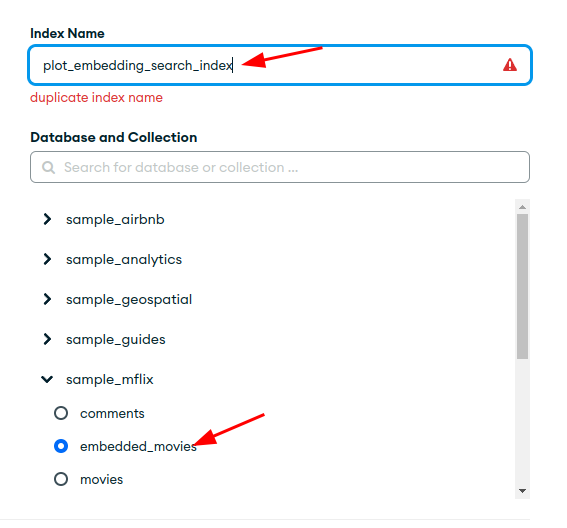

In [9]:

def vector_search(query, limit=5):
  results = collection.aggregate([
    {
        '$vectorSearch': {
            "index": "plot_embedding_search_index",
            "path": 'plot_embedding',
            "queryVector": get_embedding(query),
            "numCandidates": 50,
            "limit": limit,
        }
    }
    ])
  return results

In [10]:
query="imaginary characters from outerspace at war with earthlings"
movies = list(vector_search(query, 5))
print (f"Found {len (movies)} movies")
for movie in movies:
    print(f'Movie Name: {movie["title"]},\nMovie Plot: {movie["plot"]}\n')

OperationFailure: PlanExecutor error during aggregation :: caused by :: plot_embedding is not indexed as knnVector, full error: {'ok': 0.0, 'errmsg': 'PlanExecutor error during aggregation :: caused by :: plot_embedding is not indexed as knnVector', 'code': 8, 'codeName': 'UnknownError', '$clusterTime': {'clusterTime': Timestamp(1702457136, 15), 'signature': {'hash': b'\t\x05f\xbfj\x95\xf0\xbeF\xc7&\xe8\xdb\xecYx\xad\xa5|>', 'keyId': 7263064102996541442}}, 'operationTime': Timestamp(1702457136, 15)}

In [ ]:
## Close connection

# mongodb_client.close()